In [1]:
# # Install pyspark

# !pip install pyspark
# !pip install -U -q PyDrive
# !apt install openjdk-8-jdk-headless -qq

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [103]:
# Import libraries

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil
import time
import math
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import pandas
import similaritymeasures
# from google.colab import drive

In [3]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

# Create spark context
sc = spark.sparkContext

# Check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

24/05/28 09:46:41 WARN Utils: Your hostname, Kaitlyns-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.19.126.11 instead (on interface en0)
24/05/28 09:46:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/28 09:46:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Total Memory Allocated to Spark Runtime: 8 GB


In [4]:
# Mount google drive
# drive.mount('/content/drive')

In [7]:
# Load data
folder = 'data/2023-citibike-tripdata/9_September/'
name = '202309-citibike-tripdata_4.csv'
path = folder + name

sep23_data = spark.read.csv(path, sep = ',', header = True, inferSchema = True)

In [8]:
# Choose which data-set
data = sep23_data

# View data
print(f"NUM DATA POINTS = {data.count()}")
data.show()

NUM DATA POINTS = 575162
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|E7CE7CE80519EB26| classic_bike|2023-09-16 17:15:28|2023-09-16 17:19:00|Halsey St & Ralph...|         4334.02|Broadway & Madiso...|       4483.10|          40.68494|         -73.92299|         40.68822|         -73.91966|       member|
|56F4C65B769CF128| classic_bike

In [9]:
# Project only relevant columns
projected_data = data.select("started_at", "ended_at", "start_lat", "start_lng",
                  "end_lat", "end_lng")

# Select a small sample (first N) of rows
N = 1000
small_data = projected_data.select("*").limit(N)
small_data.show()

+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|         started_at|           ended_at|         start_lat|         start_lng|          end_lat|           end_lng|
+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|2023-09-16 17:15:28|2023-09-16 17:19:00|          40.68494|         -73.92299|         40.68822|         -73.91966|
|2023-09-03 21:45:29|2023-09-03 21:53:33|       40.73240447|     -73.998393893|        40.722055|        -73.989111|
|2023-09-06 11:59:58|2023-09-06 12:23:02| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-20 09:09:07|2023-09-20 09:14:27|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|
|2023-09-06 20:34:25|2023-09-06 20:41:56| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-06 21:14:06|2023-09-06 21:36:29| 40.78232260730881|-73.

In [10]:
# Function to process start and end times of day into pure seconds

def extract_times_to_seconds(rdd):


    # Split started_at and ended_at columns into date and time
    rdd = rdd.withColumn("start_date", split(col("started_at"), " ")[0]) \
          .withColumn("start_time", split(col("started_at"), " ")[1]) \
          .withColumn("end_date", split(col("ended_at"), " ")[0]) \
          .withColumn("end_time", split(col("ended_at"), " ")[1])


    # Drop the original started_at and ended_at columns
    rdd = rdd.drop("started_at", "ended_at")


    # Split the time strings into hours, minutes, and seconds
    rdd = rdd.withColumn("start_time_split", split(col("start_time"), ":")) \
          .withColumn("end_time_split", split(col("end_time"), ":"))


    # Convert hours, minutes, seconds to seconds
    rdd = rdd.withColumn("start_seconds",
                      col("start_time_split")[0].cast("int") * 3600 +
                      col("start_time_split")[1].cast("int") * 60 +
                      col("start_time_split")[2].cast("int")) \
          .withColumn("end_seconds",
                      col("end_time_split")[0].cast("int") * 3600 +
                      col("end_time_split")[1].cast("int") * 60 +
                      col("end_time_split")[2].cast("int"))


    # Drop intermediate columns
    rdd = rdd.drop("start_time_split", "end_time_split")


    # Drop all date and time columns EXCEPT for the new 'seconds' columns
    rdd = rdd.drop("start_date", "start_time", "end_date", "end_time")


    return rdd


# Test function
test = extract_times_to_seconds(small_data)
test.show()

+------------------+------------------+-----------------+------------------+-------------+-----------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_seconds|end_seconds|
+------------------+------------------+-----------------+------------------+-------------+-----------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|        62128|      62340|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|        78329|      78813|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        43198|      44582|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|        32947|      33267|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        74065|      74516|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        76446|      77789|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.966800570487

In [11]:
# Function to compute the true distance between two points on Earth's surface

def haversine(lat1, lon1, lat2, lon2):


    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)


    # Radius of the Earth in kilometers
    radius = 6371.0


    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c


    return distance

In [12]:
# Helper function to find the distance between the starting points of two trips
def starts_dist(u, v):

    lat1 = u[0]
    lon1 = u[1]
    lat2 = v[0]
    lon2 = v[1]

    return haversine(lat1, lon1, lat2, lon2);


# Helper function to find the distance between the ending points of two trips
def ends_dist(u, v):

    lat1 = u[2]
    lon1 = u[3]
    lat2 = v[2]
    lon2 = v[3]

    return haversine(lat1, lon1, lat2, lon2);


# Function to find the sine of the angle between two vectors
# May only use this if we resort to straight-line approximations
def sine_vecs(a, b):
    return np.abs(np.cross(a, b)) / (np.linalg.norm(a) * np.linalg.norm(b));

In [13]:
##
# Function to find the initial bearing from start station to end station
#

def calculate_initial_bearing(lat1, lon1, lat2, lon2):

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)

    initial_bearing = math.atan2(y, x)

    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [14]:
# Function to calculate the absolute value of the sine of the difference in
# initial bearings between two trips

def sine_bearings(u, v):

    u_bearing = calculate_initial_bearing(u[0], u[1], u[2], u[3])
    v_bearing = calculate_initial_bearing(v[0], v[1], v[2], v[3])

    # Convert to radians
    u_bearing = math.radians(u_bearing)
    v_bearing = math.radians(v_bearing)

    return np.sin(u_bearing - v_bearing)

In [15]:
# Function to calculate the spatial cost between two trips
# cost = dist(start1, start2) + dist(end1, end2) + gamma * sin(theta)
# where theta is the difference in initial bearings of the two trips

def spatial_cost(u, v, gamma):

    gamma = gamma # just guessing this hyper-parameter for now
                  # 12.65 = 0.5*(length + width) of Manhattan

    # Calculate the cost according to the formula
    cost = starts_dist(u, v) + ends_dist(u, v) + gamma * np.abs(sine_bearings(u, v))

    return cost

In [16]:
##
# K-means algorithm 3
#
# Now, let's add in space, using the cost formula developed above.
# For now, I'm just going to implement a simple average of the latitudes and
# longitudes to get the centroids, and not worry about the curvature of the
# Earth (though everything else so far accounts for curvature)

# Start time will be hard-coded as column index 4 for now

def K_means_time_and_space(data, centroids, max_iter, norm, lam, gam):

    # The number of seconds in a day (will need later):
    s = 24 * 60 * 60

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the custom distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # get the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]

              # start by calculating the time cost
              x_start_time = x_row[4]
              c_start_time = c_row[4]


              # perform the wrap-around, finding the minimum distance in 24-hour
              # time
              dists[i] = lam * np.min([np.abs(x_start_time - c_start_time),
                                 s - np.abs(x_start_time - c_start_time)])


              # now add the spatial cost
              dists[i] += (1 - lam) * spatial_cost(x_row[:4], c_row[:4], gam)




            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids


    # return the costs, new centroids, and cluster assignments
    return costs, new_centroids, clusters;

In [15]:
# ##
# # K-means algorithm 4
# #
# # All spatial calculations are Euclidean approximations


# # Start time will be hard-coded as column index 4 for now

# def K_means_time_and_space(data_arr, centroid_arr, max_iter, norm, lam, gam):

#     # The number of seconds in a day (will need later):
#     s = 24 * 60 * 60

#     # set the number of iterations for K-means
#     MAX_ITER = max_iter + 1

#     # initialize the cost associated with each iteration
#     costs = np.zeros(MAX_ITER)


#     # outer-most loop for k-means iterations
#     for t in np.arange(MAX_ITER):

#         # will store the index corresponding to the cluster into which each
#         # point is partitioned
#         clusters = np.zeros(data_arr.shape[0])

#         # will store the new centroids computed from each iteration
#         new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

#         # will store the count of the number of points falling into each
#         # cluster
#         point_count = np.zeros([centroid_arr.shape[0], 1])


#         # loop over each row in the data
#         for j in np.arange(data_arr.shape[0]):

#             # will store the 2-norm distance from the current row of the data
#             # to each centroid
#             dists = np.zeros(centroid_arr.shape[0])


#             # loop over each centroid
#             for i in np.arange(centroid_arr.shape[0]):

#               # get the current row, centroid pair
#               x_row = data_arr[j]
#               c_row = centroid_arr[i]

#               # start by calculating the time cost
#               x_start_time = x_row[4]
#               c_start_time = c_row[4]


#               # perform the wrap-around, finding the minimum distance in 24-hour
#               # time
#               dists[i] = lam * np.min([np.abs(x_start_time - c_start_time),
#                                  s - np.abs(x_start_time - c_start_time)])


#               # now add the spatial cost
#               # dists[i] += (1 - lam) * spatial_cost(x_row[:4], c_row[:4], gam)
#               spatial_cost = 0
#               spatial_cost += np.linalg.norm(x_row[:2] - c_row[:2], 2)
#               spatial_cost += np.linalg.norm(x_row[2:4] - c_row[2:4], 2)
#               spatial_cost += gam * np.abs(sine_bearings(x_row[:4], c_row[:4]))
#               dists[i] += (1 - lam) * spatial_cost
#               # print(dists[i])



#             # determine the (index of the) cluster with the closest centroid
#             # to x_row
#             clusters[j] = np.argmin(dists)

#             # add the current x_row to the row in the array of new centroids
#             # corresponding to the cluster x_row falls into
#             new_centroids[int(clusters[j]), :] += x_row
#             point_count[int(clusters[j])] += 1

#             # store the cost(s) associated with the current x_row
#             costs[t] += np.power(dists[int(clusters[j])], norm)

#         # divide by the number of points in each cluster to obtain the new
#         # centroids
#         new_centroids = new_centroids / point_count
#         centroid_arr = new_centroids


#     # return the costs, new centroids, and cluster assignments
#     return costs, new_centroids, clusters;

In [17]:
# Collect working data-set into an array
small_time_and_space = extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# Set k, the number of clusters for K-means
k = 10
lam = 5e-8
gam = 12.65 / 3

# Pick the first k points as a "random" initialization of centroids
random_centroids = small_time_and_space_arr[:k]

print(small_time_and_space_arr.shape)
print(random_centroids.shape)



# Run k-means time & space algorithm on small_space_and_time data
# lam (a hyper-parameter between 0 and 1) controls how much we weight space
# vs. time in our calculation of the cost. The smaller lam is, the more space
# is weighted.
costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                                                      random_centroids,
                                                      max_iter = 20, norm = 2,
                                                      lam = lam,
                                                      gam = gam)
# NOTE: As of now, lam = 1e-1 gives time dominating, and lam = 1e-6 gives space
# dominating

print(costs[-1])
print(centroids) # end times don't have meaning here
print(clustering[:20])

## Time to run ##

# 1,000 points, 100 iterations, 5 clusters = 12 seconds (TPU)

(1000, 6)
(10, 6)
26458.67634910942
[[ 4.07163685e+01 -7.39498774e+01  4.07152906e+01 -7.39508230e+01
   5.28944628e+04  5.34622181e+04]
 [ 4.07253671e+01 -7.39908341e+01  4.07218080e+01 -7.39918022e+01
   5.34238029e+04  5.36768894e+04]
 [ 4.07826239e+01 -7.39637194e+01  4.07878745e+01 -7.39692240e+01
   5.57364310e+04  5.65807414e+04]
 [ 4.07639214e+01 -7.39106606e+01  4.07598617e+01 -7.39139570e+01
   5.14304510e+04  5.20743922e+04]
 [ 4.07496494e+01 -7.39750717e+01  4.07687015e+01 -7.39540704e+01
   5.24543958e+04  5.34688125e+04]
 [ 4.08080916e+01 -7.39561667e+01  4.07986941e+01 -7.39648049e+01
   4.90246197e+04  4.84815070e+04]
 [ 4.07723647e+01 -7.39471215e+01  4.07716904e+01 -7.39361537e+01
   5.98756000e+04  5.64704000e+04]
 [ 4.06801198e+01 -7.39738784e+01  4.06797431e+01 -7.39677011e+01
   5.22942123e+04  5.28861453e+04]
 [ 4.07634039e+01 -7.39786373e+01  4.07904133e+01 -7.39678325e+01
   5.28013259e+04  5.27351111e+04]
 [ 4.08607321e+01 -7.39127583e+01  4.08570515e+01 -7.39

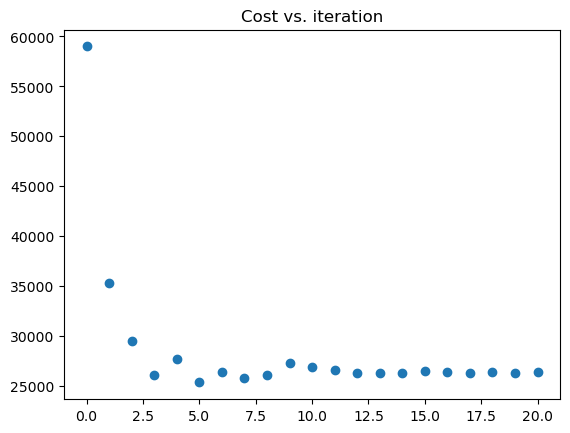

In [18]:
##
# Visualization and validation
#

iterations = np.arange(costs.shape[0])
plt.scatter(iterations, costs)
plt.title("Cost vs. iteration")
plt.show()

In [19]:
def custom_distance_metric(x_row, c_row, lam, gam):

    dist = 0
    s = 24 * 60 * 60

    # start by calculating the time cost
    x_start_time = x_row[4]
    c_start_time = c_row[4]


    # perform the wrap-around, finding the minimum distance in 24-hour
    # time
    dist = lam * np.min([np.abs(x_start_time - c_start_time),
                                 s - np.abs(x_start_time - c_start_time)])

    # now add the spatial cost
    dist += (1 - lam) * spatial_cost(x_row[:4], c_row[:4], gam)

    return dist



def silhouette_score_custom(X, labels, custom_distance, lam, gam):

    n_samples = len(X)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Initialize silhouette scores
    silhouette_scores = np.zeros(n_samples)

    # Compute a and b for each sample
    for i in range(n_samples):
        # Points in the same cluster
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # exclude the point itself

        # Compute a (mean intra-cluster distance)
        a = np.mean([custom_distance(X[i], X[j], lam, gam) for j in range(n_samples) if same_cluster[j]])

        # Compute b (mean nearest-cluster distance)
        b = np.inf
        for label in unique_labels:
            if label == labels[i]:
                continue
            other_cluster = (labels == label)
            mean_distance = np.mean([custom_distance(X[i], X[j], lam, gam) for j in range(n_samples) if other_cluster[j]])
            if mean_distance < b:
                b = mean_distance

        # Silhouette score for the sample
        silhouette_scores[i] = (b - a) / np.max([a, b])

    # Overall silhouette score
    overall_silhouette_score = np.mean(silhouette_scores)
    return overall_silhouette_score, silhouette_scores




In [20]:
# Search for best lambda

X = small_time_and_space_arr

for i in [-4, -5, -6, -7, -8]:
    # Set k, the number of clusters for K-means
    k = 10
    lam = 5 * 10**i
    gam = 12.65 / 3

    # Pick the first k points as a "random" initialization of centroids
    random_centroids = small_time_and_space_arr[:k]


    # Run k-means time & space algorithm on small_space_and_time data
    # lam (a hyper-parameter between 0 and 1) controls how much we weight space
    # vs. time in our calculation of the cost. The smaller lam is, the more space
    # is weighted.
    costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                                                          random_centroids,
                                                          max_iter = 20, norm = 2,
                                                          lam = lam,
                                                          gam = gam)
    # NOTE: As of now, lam = 1e-1 gives time dominating, and lam = 1e-6 gives space
    # dominating


    overall_score, sample_scores = silhouette_score_custom(X, clustering, custom_distance_metric, lam, gam)
    print(f"Lambda = {lam}  Overall Silhouette Score {overall_score}")

Lambda = 0.0005  Overall Silhouette Score 0.2352587415397677
Lambda = 5e-05  Overall Silhouette Score 0.3308899282968399
Lambda = 4.9999999999999996e-06  Overall Silhouette Score 0.3571927183473143
Lambda = 5e-07  Overall Silhouette Score 0.37513461350509886
Lambda = 5e-08  Overall Silhouette Score 0.3701010130314824


In [21]:
# Search for best gamma

X = small_time_and_space_arr

for i in [5, 6, 7, 8, 9]:
    # Set k, the number of clusters for K-means
    k = 10
    lam = 5 * 10**(-7)
    gam = 12.65 / i

    # Pick the first k points as a "random" initialization of centroids
    random_centroids = small_time_and_space_arr[:k]


    # Run k-means time & space algorithm on small_space_and_time data
    # lam (a hyper-parameter between 0 and 1) controls how much we weight space
    # vs. time in our calculation of the cost. The smaller lam is, the more space
    # is weighted.
    costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                                                          random_centroids,
                                                          max_iter = 20, norm = 2,
                                                          lam = lam,
                                                          gam = gam)
    # NOTE: As of now, lam = 1e-1 gives time dominating, and lam = 1e-6 gives space
    # dominating


    overall_score, sample_scores = silhouette_score_custom(X, clustering, custom_distance_metric, lam, gam)
    print(f"Gamma = {gam}  Overall Silhouette Score {overall_score}")

Gamma = 2.5300000000000002  Overall Silhouette Score 0.3941810027335937
Gamma = 2.1083333333333334  Overall Silhouette Score 0.3549886447631345
Gamma = 1.8071428571428572  Overall Silhouette Score 0.37653304309680574
Gamma = 1.58125  Overall Silhouette Score 0.39029885774475864
Gamma = 1.4055555555555557  Overall Silhouette Score 0.3953100606325951


In [ ]:
# search for best k

X = small_time_and_space_arr

for i in range(10):
    # Set k, the number of clusters for K-means
    k = i
    lam = 5e-07
    gam = 1.4055555555555557

    # Pick the first k points as a "random" initialization of centroids
    random_centroids = small_time_and_space_arr[:k]


    # Run k-means time & space algorithm on small_space_and_time data
    # lam (a hyper-parameter between 0 and 1) controls how much we weight space
    # vs. time in our calculation of the cost. The smaller lam is, the more space
    # is weighted.
    costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                                                          random_centroids,
                                                          max_iter = 20, norm = 2,
                                                          lam = lam,
                                                          gam = gam)
    # NOTE: As of now, lam = 1e-1 gives time dominating, and lam = 1e-6 gives space
    # dominating

    # calculate within sum of squares
    # HERE


    overall_score, sample_scores = silhouette_score_custom(X, clustering, custom_distance_metric, lam, gam)
    print(f"Lambda = {lam}  Overall Silhouette Score {overall_score}")

## Other distance metrics to compare:
### NOTE: DATA SHOULD BE NORMALIZED AT THIS POINT
- Euclidean lock step
- Dynamic time warping
- (Discrete) Frechet distance

do the latter two collapse into euclidean when comparing two straight lines defined by two points? no, they tell us slightly different things

https://pypi.org/project/similaritymeasures/


In [83]:
# distance metrics for k-means:
# custom_distance_metric: spatiotemporally aware
# euclidean_lockstep, dtw, discrete_frechet

def euclidean_dist(xrow, crow, lam=None, gam=None):
    return np.linalg.norm(xrow-crow)

def dtw(xrow, crow, lam=None, gam=None):
    # reformat to [(lat, lng, time), (lat, lng, time)]
    x = np.array([[xrow[0], xrow[1], xrow[4]],[xrow[2], xrow[3], xrow[5]]])
    c = np.array([[crow[0], crow[1], crow[4]],[crow[2], crow[3], crow[5]]])

    # calculate distance
    return similaritymeasures.dtw(x, c)[0]

def discrete_frechet(xrow, crow, lam=None, gam=None):
    # reformat to [(lat, lng, time), (lat, lng, time)]
    x = np.array([[xrow[0], xrow[1], xrow[4]],[xrow[2], xrow[3], xrow[5]]])
    c = np.array([[crow[0], crow[1], crow[4]],[crow[2], crow[3], crow[5]]])

    # calculate distance
    return similaritymeasures.frechet_dist(x, c)


## hyperparameter tuning: k, lambda

In [ ]:
# elbow plot
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

# just with sklean
for i in range(1, 11):
    kmeanModel = KMeans(n_clusters=i).fit(X)
    kmeanModel.fit(X)

    # print(np.sum(np.min(cdist(X, kmeanModel.cluster_centers_,
    #                                         'euclidean'), axis=1)))

    distortions.append(np.sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = np.sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

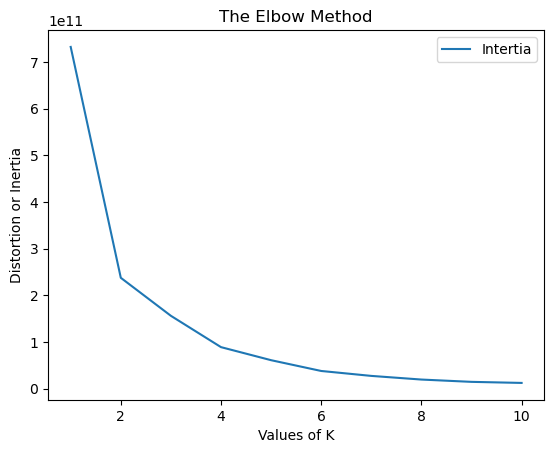

In [129]:
# plt.plot(np.arange(1,11), distortions, 'bx-', label='Distortion')
plt.plot(np.arange(1,11), inertias, label='Intertia')
plt.xlabel('Values of K')
plt.ylabel('Distortion or Inertia')
plt.title('The Elbow Method')
plt.legend()
plt.show()

### trying out k-means with multiple distance metrics

In [85]:
def K_means_time_and_space(data, centroids, max_iter, norm, lam, gam, dist_func):

    # The number of seconds in a day (will need later):
    s = 24 * 60 * 60

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the custom distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # get the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]

              # calculate distance
              dists[i] = dist_func(x_row, c_row, lam, gam)

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids


    # return the costs, new centroids, and cluster assignments
    return costs, new_centroids, clusters;

In [126]:
# Set k, the number of clusters for K-means
k = 4
lam = 5e-7
gam = 1.4055555555555557

# Pick the first k points as a "random" initialization of centroids
random_centroids = small_time_and_space_arr[:k]

# compare sillhouette scores, runtime
measures = [custom_distance_metric, euclidean_dist, dtw, discrete_frechet] 
runtimes = []
silhouettes = []
for measure in measures:
    print(measure)
    # run algorithm
    t0 = time.time()
    costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                            random_centroids,
                            max_iter = 20, norm = 2,
                            lam = lam,
                            gam = gam,
                            dist_func=measure)
    runtimes.append(time.time()-t0)

    # compute silhouette
    print('computing silhouette')
    overall_score, sample_scores = silhouette_score_custom(small_time_and_space_arr, clustering, measure, lam, gam)
    silhouettes.append(overall_score)

<function custom_distance_metric at 0x17b22e520>
computing silhouette
<function euclidean_dist at 0x1289c45e0>
computing silhouette
<function dtw at 0x1289c7380>
computing silhouette
<function discrete_frechet at 0x1288c74c0>
computing silhouette


In [127]:
funcs = ["Custom", "Euclidean", "DTW", "Discrete Frechet"]

results = pd.DataFrame(index=funcs)
results["runtime"] = runtimes
results["silhouette"] = silhouettes

In [128]:
results

,runtime,silhouette
Custom,1.432993,0.446786
Euclidean,0.406367,0.496922
DTW,1.008570,0.540789
Discrete Frechet,1.222997,0.486332


## Altair map with time slider to visualize clusters